<a href="https://colab.research.google.com/github/arvind2047/gl_capstone/blob/interim_week1_workarea/GL_AIML_Capstone_Sep2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CAPSTONE PROJECT: AUTOMATIC TICKET ASSIGNMENT**


#### Problem Statement:

Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 

Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service. Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

#### The objective of the project is,
 Learn how to use different classification models.

 Use transfer learning to use pre-built models. 

 Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.

 Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.


In [ ]:
#Importing libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import scipy.stats as st

import keras 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Setup project path:
import os
os.chdir('/content/drive/My Drive/GL AIML Capstone')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [ ]:
import os
#project_path = '/content/drive/My Drive/Capstone Project NLP/' 
project_path = '/content/drive/My Drive/GL AIML Capstone/' 
os.chdir(project_path) 
os.getcwd()

'/content/drive/My Drive/GL AIML Capstone'

In [ ]:
# read and load data
## Read the data from EXCEL
incidents = pd.read_excel(project_path + "input_data.xlsx")

## Quick View 
incidents.head(3)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0


In [ ]:
## basic info
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [ ]:
## Shape
incidents.shape

(8500, 4)

In [ ]:
incidents.columns

Index(['Short description', 'Description', 'Caller', 'Assignment group'], dtype='object')

In [ ]:
incidents["Assignment group"].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [ ]:
incidents["Assignment group"].nunique()

74

In [ ]:
## find nulls
incidents[incidents.isnull().any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [ ]:
## find NA
incidents[incidents.isna().any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [ ]:
# drop nulls
incidents.dropna(inplace=True)
incidents.shape

(8491, 4)

In [ ]:
## Duplicates 
sub_incidents = incidents[['Short description', 'Description', 'Caller','Assignment group']].copy()
duplicateRowsDF = sub_incidents[sub_incidents.duplicated()]
duplicateRowsDF

,Short description,Description,Caller,Assignment group
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0
229,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0
493,ticket update on inplant_872730,ticket update on inplant_872730,fumkcsji sarmtlhy,GRP_0
512,blank call //gso,blank call //gso,rbozivdq gmlhrtvp,GRP_0
667,job bkbackup_tool_powder_prod_full failed in j...,received from: monitoring_tool@company.com\r\n...,bpctwhsn kzqsbmtp,GRP_8
...,...,...,...,...
7836,probleme mit erpgui \tmqfjard qzhgdoua,probleme mit erpgui \tmqfjard qzhgdoua,tmqfjard qzhgdoua,GRP_24
8051,issue on pricing in distributor_tool,we have agreed price with many of the distribu...,hbmwlprq ilfvyodx,GRP_21
8093,reset passwords for prgthyuulla ramdntythanjes...,the,boirqctx bkijgqry,GRP_17
8347,blank call // loud noise,blank call // loud noise,rbozivdq gmlhrtvp,GRP_0


In [ ]:
# Remove Duplicates
incidents_upd = incidents.drop_duplicates(['Short description', 'Description', 'Caller', 'Assignment group'])

#### Basic cleansing of data

In [ ]:
# before removing caller we can see that similar string is present in description, we can clean decription first


incidents_upd['Caller email'] = incidents_upd.apply(lambda x: x['Caller'].replace(' ', '.'), axis=1)
incidents_upd['Caller email'] = incidents_upd.apply(lambda x: x['Caller email'] + '@gmail.com', axis=1)
incidents_upd.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Short description,Description,Caller,Assignment group,Caller email
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,spxjnwir.pjlcoqds@gmail.com
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,hmjdrvpb.komuaywn@gmail.com
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,eylqgodm.ybqkwiam@gmail.com
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,xbkucsvz.gcpydteq@gmail.com
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,owlgqjme.qhcozdfx@gmail.com
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,eflahbxn.ltdgrvkz@gmail.com
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,jyoqwxhz.clhxsoqy@gmail.com
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,eqzibjhw.ymebpoih@gmail.com
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,mdbegvct.dbvichlg@gmail.com
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,fumkcsji.sarmtlhy@gmail.com


In [ ]:
incidents_upd['Description']=incidents_upd.apply(lambda x: x['Description'].replace(x['Caller email'], ''), axis=1)
incidents_upd.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Short description,Description,Caller,Assignment group,Caller email
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,spxjnwir.pjlcoqds@gmail.com
1,outlook,"\r\n\r\nreceived from: \r\n\r\nhello team,\r\n...",hmjdrvpb komuaywn,GRP_0,hmjdrvpb.komuaywn@gmail.com
2,cant log in to vpn,\r\n\r\nreceived from: \r\n\r\nhi\r\n\r\ni can...,eylqgodm ybqkwiam,GRP_0,eylqgodm.ybqkwiam@gmail.com
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,xbkucsvz.gcpydteq@gmail.com
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,owlgqjme.qhcozdfx@gmail.com
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,eflahbxn.ltdgrvkz@gmail.com
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,jyoqwxhz.clhxsoqy@gmail.com
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,eqzibjhw.ymebpoih@gmail.com
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,mdbegvct.dbvichlg@gmail.com
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,fumkcsji.sarmtlhy@gmail.com


In [ ]:
# Observation :: caller column is useless and can be dropped

incidents_upd = incidents_upd.drop(['Caller'],axis=1)
incidents_upd = incidents_upd.drop(['Caller email'],axis=1)

In [ ]:
#remove spaces trailing
incidents_upd['Short description'] = incidents_upd['Short description'].str.strip()
incidents_upd['Description'] = incidents_upd['Description'].str.strip()

#remove tabs and carriage returns
incidents_upd.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

#Getting rid of numbers & special characters etc

spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    incidents_upd['Short description'] = incidents_upd['Description'].str.replace(char, ' ')
    incidents_upd['Description'] = incidents_upd['Description'].str.replace(char, ' ')

#remove numbers    
incidents_upd['Description'] = incidents_upd['Description'].replace('\d+', '', regex=True)
incidents_upd['Short description'] = incidents_upd['Short description'].replace('\d+', '', regex=True)
    
#remove more than 1 space
incidents_upd.replace('\s+', ' ', regex=True, inplace=True)

#make lower case
incidents_upd.apply(lambda x: x.astype(str).str.lower())

incidents_upd.head(10)

,Short description,Description,Assignment group
0,verified user details employee manager name c...,verified user details employee manager name c...,GRP_0
1,received from hello team my meetings skype mee...,received from hello team my meetings skype mee...,GRP_0
2,received from hi i cannot log on to vpn best,received from hi i cannot log on to vpn best,GRP_0
3,unable to access hr tool page,unable to access hr tool page,GRP_0
4,skype error,skype error,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,GRP_0
6,event critical HostName company com the value ...,event critical HostName company com the value ...,GRP_1
7,ticket no employment status new non employee e...,ticket no employment status new non employee e...,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,GRP_0
9,ticket update on inplant,ticket update on inplant,GRP_0


In [ ]:
#merge short Description & Description

incidents_upd['isSubstr'] = incidents_upd.apply(lambda x: x['Short description'] not in x['Description'], axis=1)

#Now we see many places short description is redundant. We will append short description to description if True only then drop short descrition
incidents_upd_combined = incidents_upd.copy()
incidents_upd_combined.loc[incidents_upd_combined['isSubstr'] == True, 'Description'] = incidents_upd_combined['Short description'] + " "+ incidents_upd_combined['Description']
#Drop Short description
incidents_upd_combined = incidents_upd_combined.drop(['Short description'],axis=1)
incidents_upd_combined = incidents_upd_combined.drop(['isSubstr'],axis=1)
incidents_upd_combined.tail(10)

,Description,Assignment group
8490,please contact ed pasgryowski pasgryo about hi...,GRP_29
8491,received from i need a vpn for my new laptop n...,GRP_34
8492,hr tool etime option not visitble,GRP_0
8493,i am sorry i have another two accounts that ne...,GRP_10
8494,tablet needs reimaged due to multiple issues w...,GRP_3
8495,received from good afternoon i am not receivin...,GRP_29
8496,telephony software issue,GRP_0
8497,vip windows password reset for tifpdchb pedxruyf,GRP_0
8498,i am unable to access the machine utilities to...,GRP_62
8499,an mehreren pc s lassen sich verschiedene prgr...,GRP_49


In [ ]:
## Group by Categories
df_grp = incidents_upd_combined.groupby(['Assignment group']).size().reset_index(name='counts')
df_grp

,Assignment group,counts
0,GRP_0,3926
1,GRP_1,31
2,GRP_10,140
3,GRP_11,30
4,GRP_12,257
...,...,...
69,GRP_71,2
70,GRP_72,2
71,GRP_73,1
72,GRP_8,645


In [ ]:
df_grp.describe()

,counts
count,74.000000
mean,113.621622
std,459.823990
min,1.000000
25%,5.250000
50%,26.000000
75%,81.000000
max,3926.000000


In [ ]:
df_grp.isna().sum()

Assignment group    0
counts              0
dtype: int64


**Observation**

* The Target class distrubtion is extremely skewed
* Large no of entries for GRP_0 (mounting to 3926) which account for ~50% of the data
* There are groups with 1 entry also. Need to merge all groups with small entries to a group to reduce the imbalance in the target. This may reduce the imbalance to some extent.

#### Fix the class imbalance

In [ ]:
sample = incidents_upd_combined.groupby(['Assignment group'])
regroup=[]
for grp in incidents_upd_combined['Assignment group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have less than 10 samples'.format(len(regroup)))
incidents_upd_combined['Assignment group']=incidents_upd_combined['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
incidents_upd_combined['Assignment group'].unique()

Found 25 groups which have less than 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

### Text Pre-processing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


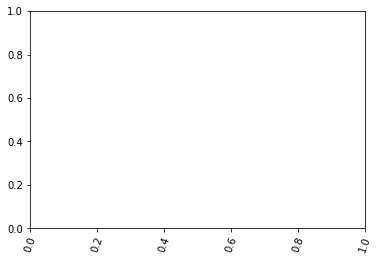

In [ ]:
import nltk
import string
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 1.9MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3019520 sha256=3cf86d2d8be41aac793cbca83b74187db81e737616c16bbc199d57d90bffc30f
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
!pip install contractions

     |████████████████████████████████| 317kB 3.9MB/s 
     |████████████████████████████████| 245kB 8.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81701 sha256=d7d5ca8cdce40b0932883eed5589edade755c85e1c82b536508a0ec9b77f6103
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
import contractions
import fasttext

In [ ]:
!pip install gensim
!pip install bs4
!pip install pyLDAvis
!pip install warnings

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 15.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=9ec0e166e55da62c8cbff0d665adf2e3405813b624b99012739ee6dd06bd94a7
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=cfcccfcb2019c8a60bbc65700cf8519dbe88027fd77fba9e8e18ee452a6de5b4
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


#### Get the frequency of words in Description Column

In [ ]:
# function to plot most frequent terms. This is used to gauge the quality of text processing
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

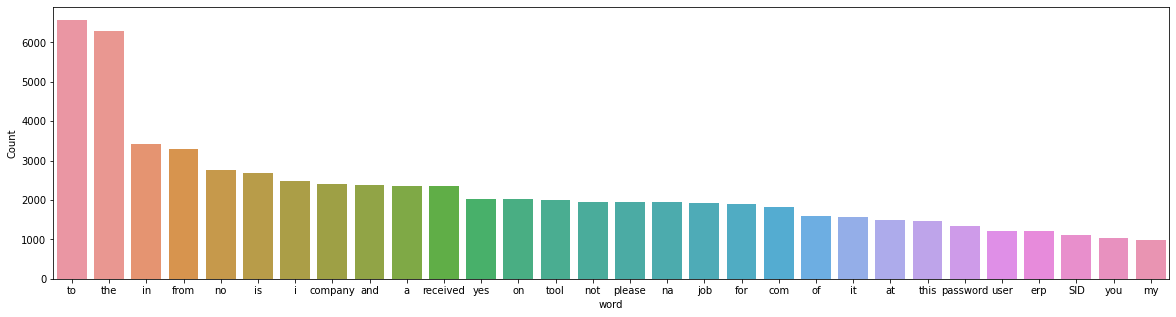

In [ ]:
freq_words(list(incidents_upd_combined['Description']))

#### Expand the contractions

In [ ]:
'''
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the description
incidents_upd['Description']=incidents_upd['Description'].apply(lambda x:expand_contractions(x))
'''

In [ ]:
'''
# Expanding Contractions in the short description
incidents_upd['Short description']=incidents_upd['Short description'].apply(lambda x:expand_contractions(x))
'''

In [ ]:
'''
incidents_upd.head(5)
'''

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the ...,spxjnwir pjlcoqds,GRP_0
1,outlook,"\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype m...",hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
incidents_upd_combined['Description_Expanded'] = incidents_upd_combined['Description'].apply(lambda x: [contractions.fix(word) for word in x.split()])

#Convert the expanded column to string
incidents_upd_combined['Description_Expanded_Str'] = [' '.join(map(str, l)) for l in incidents_upd_combined['Description_Expanded']]
incidents_upd_combined.head()

,Description,Assignment group,Description_Expanded,Description_Expanded_Str
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page
4,skype error,GRP_0,"[skype, error]",skype error


#### English Language Detection

In [ ]:
pretrained_model = project_path + "lid.176.bin" 
model = fasttext.load_model(pretrained_model)
langs = []
for sent in incidents_upd_combined['Description_Expanded_Str']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])
incidents_upd_combined['langs'] = langs

incidents_upd_combined.head(10)

,Description,Assignment group,Description_Expanded,Description_Expanded_Str,langs
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...,en
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,en
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best,en
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page,en
4,skype error,GRP_0,"[skype, error]",skype error,ja
5,unable to log in to engineering tool and skype,GRP_0,"[unable, to, log, in, to, engineering, tool, and, skype]",unable to log in to engineering tool and skype,en
6,event critical HostName company com the value of mountpoint threshold for oracle SID erpdata srp...,GRP_1,"[event, critical, HostName, company, com, the, value, of, mountpoint, threshold, for, oracle, SI...",event critical HostName company com the value of mountpoint threshold for oracle SID erpdata srp...,en
7,ticket no employment status new non employee enter user s name,GRP_0,"[ticket, no, employment, status, new, non, employee, enter, user, s, name]",ticket no employment status new non employee enter user s name,en
8,unable to disable add ins on outlook,GRP_0,"[unable, to, disable, add, ins, on, outlook]",unable to disable add ins on outlook,en
9,ticket update on inplant,GRP_0,"[ticket, update, on, inplant]",ticket update on inplant,en


#### Remove non-English details

In [ ]:
#checking detected languages
incidents_upd_combined['langs'].value_counts()

en    7750
de     513
zh      37
pt      15
pl      10
sv       9
ru       8
hu       7
ja       7
es       6
it       5
id       4
fi       4
nl       4
fa       3
hr       3
eo       3
fr       2
da       2
sl       2
tr       2
ko       2
kn       2
ml       1
my       1
el       1
ba       1
uk       1
ta       1
cs       1
no       1
Name: langs, dtype: int64

In [ ]:
incidents_upd_en = incidents_upd_combined[incidents_upd_combined.langs.eq('en')]
print(incidents_upd_en)

                                                                                              Description  ... langs
0      verified user details employee manager name checked the user name in ad and reset the password ...  ...    en
1     received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...  ...    en
2                                                            received from hi i cannot log on to vpn best  ...    en
3                                                                           unable to access hr tool page  ...    en
5                                                          unable to log in to engineering tool and skype  ...    en
...                                                                                                   ...  ...   ...
8494                                       tablet needs reimaged due to multiple issues with crm wifi etc  ...    en
8495    received from good afternoon i am not receiving the emai

In [ ]:
incidents_upd_en.drop('langs', inplace = True, axis=1)
incidents_upd_en.head()

,Description,Assignment group,Description_Expanded,Description_Expanded_Str
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page
5,unable to log in to engineering tool and skype,GRP_0,"[unable, to, log, in, to, engineering, tool, and, skype]",unable to log in to engineering tool and skype


#### Tokenization

In [ ]:
# Package needed for tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
incidents_upd_en['tokenized'] = incidents_upd_en['Description_Expanded_Str'].apply(word_tokenize)
incidents_upd_en.head()

,Description,Assignment group,Description_Expanded,Description_Expanded_Str,tokenized
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,..."
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o..."
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best,"[received, from, hi, i, can, not, log, on, to, vpn, best]"
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page,"[unable, to, access, hr, tool, page]"
5,unable to log in to engineering tool and skype,GRP_0,"[unable, to, log, in, to, engineering, tool, and, skype]",unable to log in to engineering tool and skype,"[unable, to, log, in, to, engineering, tool, and, skype]"


#### Converting all Characters to Lowercase

In [ ]:
incidents_upd_en['lower'] = incidents_upd_en['tokenized'].apply(lambda x: [word.lower() for word in x])
incidents_upd_en.head()

,Description,Assignment group,Description_Expanded,Description_Expanded_Str,tokenized,lower
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...","[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,..."
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...","[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o..."
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best,"[received, from, hi, i, can, not, log, on, to, vpn, best]","[received, from, hi, i, can, not, log, on, to, vpn, best]"
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page,"[unable, to, access, hr, tool, page]","[unable, to, access, hr, tool, page]"
5,unable to log in to engineering tool and skype,GRP_0,"[unable, to, log, in, to, engineering, tool, and, skype]",unable to log in to engineering tool and skype,"[unable, to, log, in, to, engineering, tool, and, skype]","[unable, to, log, in, to, engineering, tool, and, skype]"


#### Removing Punctuations

In [ ]:
punc = string.punctuation
incidents_upd_en['no_punc'] = incidents_upd_en['lower'].apply(lambda x: [word for word in x if word not in punc])
incidents_upd_en.head()

,Description,Assignment group,Description_Expanded,Description_Expanded_Str,tokenized,lower,no_punc
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...","[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...","[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,..."
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...","[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...","[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o..."
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best,"[received, from, hi, i, can, not, log, on, to, vpn, best]","[received, from, hi, i, can, not, log, on, to, vpn, best]","[received, from, hi, i, can, not, log, on, to, vpn, best]"
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page,"[unable, to, access, hr, tool, page]","[unable, to, access, hr, tool, page]","[unable, to, access, hr, tool, page]"
5,unable to log in to engineering tool and skype,GRP_0,"[unable, to, log, in, to, engineering, tool, and, skype]",unable to log in to engineering tool and skype,"[unable, to, log, in, to, engineering, tool, and, skype]","[unable, to, log, in, to, engineering, tool, and, skype]","[unable, to, log, in, to, engineering, tool, and, skype]"


#### Removing Stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
incidents_upd_en['stopwords_removed'] = incidents_upd_en['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
incidents_upd_en.head()

,Description,Assignment group,Description_Expanded,Description_Expanded_Str,tokenized,lower,no_punc,stopwords_removed
0,verified user details employee manager name checked the user name in ad and reset the password ...,GRP_0,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...",verified user details employee manager name checked the user name in ad and reset the password a...,"[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...","[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...","[verified, user, details, employee, manager, name, checked, the, user, name, in, ad, and, reset,...","[verified, user, details, employee, manager, name, checked, user, name, ad, reset, password, adv..."
1,received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,GRP_0,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...",received from hello team my meetings skype meetings etc are not appearing in my outlook calendar...,"[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...","[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...","[received, from, hello, team, my, meetings, skype, meetings, etc, are, not, appearing, in, my, o...","[received, hello, team, meetings, skype, meetings, etc, appearing, outlook, calendar, somebody, ..."
2,received from hi i cannot log on to vpn best,GRP_0,"[received, from, hi, i, cannot, log, on, to, vpn, best]",received from hi i cannot log on to vpn best,"[received, from, hi, i, can, not, log, on, to, vpn, best]","[received, from, hi, i, can, not, log, on, to, vpn, best]","[received, from, hi, i, can, not, log, on, to, vpn, best]","[received, hi, log, vpn, best]"
3,unable to access hr tool page,GRP_0,"[unable, to, access, hr, tool, page]",unable to access hr tool page,"[unable, to, access, hr, tool, page]","[unable, to, access, hr, tool, page]","[unable, to, access, hr, tool, page]","[unable, access, hr, tool, page]"
5,unable to log in to engineering tool and skype,GRP_0,"[unable, to, log, in, to, engineering, tool, and, skype]",unable to log in to engineering tool and skype,"[unable, to, log, in, to, engineering, tool, and, skype]","[unable, to, log, in, to, engineering, tool, and, skype]","[unable, to, log, in, to, engineering, tool, and, skype]","[unable, log, engineering, tool, skype]"


#### Lemmatization